In [1]:
# importing libraries
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [3]:
# load dataset
data = pd.read_csv("dataset/preprocessed.csv")
data = data.drop(data[data.target == -1].index)
data.shape

(762094, 44)

In [4]:
# Separate input features and target
targets = data.target
targets -= 1
targets.head()
targets = targets.to_numpy()

In [5]:
features = data.drop('target', axis=1)
features = features.to_numpy()

In [6]:
#split test data
X_trainAndVal, X_test, y_trainAndVal, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 0)

In [7]:
#split train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size = 0.2, random_state = 0)

In [8]:
# print distribution before re-sampling
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1      2      3      4]
 [ 50166  55949  87609 117459 176557]]


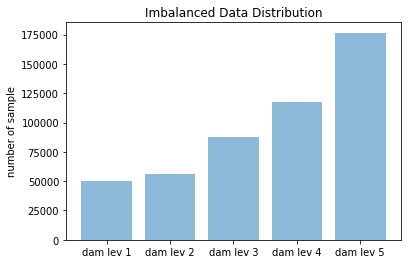

In [9]:
# plot distribution before re-sampling
objects = ('dam lev 1', 'dam lev 2', 'dam lev 3', 'dam lev 4', 'dam lev 5')
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of sample')
plt.title('Imbalanced Data Distribution')
plt.savefig("before_resampling.png")

In [10]:
# use re-sampling
sm = SMOTETomek(random_state = 27, n_jobs = -1)
X_train, y_train = sm.fit_sample(X_train, y_train)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


In [11]:
# print distribution after re-sampling
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1      2      3      4]
 [162635 155765 149211 144863 147975]]


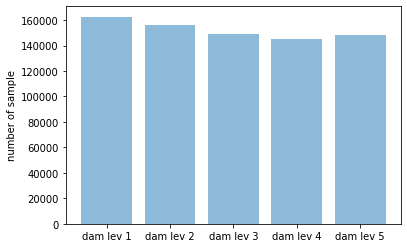

In [12]:
# plot distribution after re-sampling
objects = ('dam lev 1', 'dam lev 2', 'dam lev 3', 'dam lev 4', 'dam lev 5')
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of sample')
plt.savefig("after_resampling.png")

In [13]:
#Scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
# network settings
batch_size = 10000
epochs = 50
input_dim = 43
output_dim = 5
lr_rate = 0.01

In [15]:
#load dataset
class datasetLoad(Dataset):
    def __init__(self, features,labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
X_train = datasetLoad(X_train, y_train)
X_val = datasetLoad(X_val, y_val)

In [16]:
# Dataloader
train_loader = torch.utils.data.DataLoader(dataset = X_train, batch_size = batch_size, shuffle=True, num_workers = 1)
val_loader = torch.utils.data.DataLoader(dataset = X_val, batch_size = batch_size, shuffle=True, num_workers = 1)

In [17]:
# network
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [18]:
# create object for network
model = LogisticRegression(input_dim, output_dim)

In [19]:
# choose loss function
criterion = torch.nn.CrossEntropyLoss()

In [20]:
# choose optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

In [21]:
# convert network to GPU
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

cuda


In [22]:
# logistic regression
import datetime
a = datetime.datetime.now().replace(microsecond=0)
train_loss = []
validation_loss = []
for epoch in range(epochs):
    train_loss_val = 0.0
    num_of_train_iter = 0
    for i, (train_feature, train_label) in enumerate(train_loader):
        train_feature = Variable(train_feature)
        train_label = Variable(train_label)
        if torch.cuda.is_available():
            train_feature = train_feature.cuda()
            train_label = train_label.cuda() 
        optimizer.zero_grad()
        outputs = model(train_feature.float())
        loss = criterion(outputs.float(), train_label)
        loss.backward()
        optimizer.step()
        train_loss_val += loss.item()
        num_of_train_iter = i
        del train_feature
        del train_label        
        torch.cuda.empty_cache()
    train_loss_val /= num_of_train_iter
    validation_loss_val = 0.0
    num_of_val_iter = 0
    # calculate Accuracy
    correct = 0.0
    total = 0
    accuracy = 0.0
    for i, (features, labels) in enumerate( val_loader):
        features = Variable(features)
        labels = Variable(labels)
        if torch.cuda.is_available():
            features = features.cuda()
            labels = labels.cuda() 
        with torch.no_grad():
            outputs = model(features.float())
        loss = criterion(outputs.float(), labels)
        validation_loss_val += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
        # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
        accuracy += 100 * correct/total
        num_of_val_iter = i
        del features
        del labels        
        torch.cuda.empty_cache()
    validation_loss_val /= num_of_val_iter
    accuracy /=  num_of_val_iter
    train_loss.append(train_loss_val)
    validation_loss.append(validation_loss_val)
    if(epoch % 10 == 0):   
        print("{")
        print("Epoch: {}. Train Loss: {}. ".format(epoch, train_loss_val))
        print("Epoch: {}. Validation Loss: {}. Validation Accuracy: {}.".format(epoch, validation_loss_val, accuracy))
        print("}")

{
Epoch: 0. Train Loss: 1.6348783044438613. 
Epoch: 0. Validation Loss: 1.7101038098335266. Validation Accuracy: 31.688262939453125.
}
{
Epoch: 10. Train Loss: 1.3972916022727364. 
Epoch: 10. Validation Loss: 1.5245884358882904. Validation Accuracy: 41.711544036865234.
}
{
Epoch: 20. Train Loss: 1.3824371193584644. 
Epoch: 20. Validation Loss: 1.5127646327018738. Validation Accuracy: 43.42767333984375.
}
{
Epoch: 30. Train Loss: 1.3768082464996136. 
Epoch: 30. Validation Loss: 1.5092530647913616. Validation Accuracy: 43.49617004394531.
}
{
Epoch: 40. Train Loss: 1.3743965845358999. 
Epoch: 40. Validation Loss: 1.5086548229058583. Validation Accuracy: 43.44146728515625.
}


In [23]:
b = datetime.datetime.now().replace(microsecond=0)
print(b-a)

0:05:38


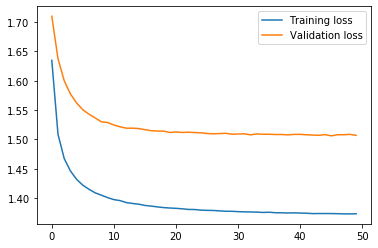

In [24]:
# plotting the training and validation loss
plt.plot(train_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend()
plt.savefig("logistic.png")

In [25]:
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [26]:
if torch.cuda.is_available():
    X_test = X_test.cuda()
    y_test = y_test.cuda() 

In [27]:
# calculate test results
with torch.no_grad():
    outputs = model(X_test.float())
_, predicted = torch.max(outputs.data, 1)

In [28]:
# print results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: \t", accuracy_score(y_test.cpu(), predicted.cpu()))
print("F1 Score: \t", f1_score(y_test.cpu(), predicted.cpu(), average = 'macro'))
print("Precision:\t", precision_score(y_test.cpu(), predicted.cpu(), average = 'macro'))
print("Recall:   \t", recall_score(y_test.cpu(), predicted.cpu(), average = 'macro'))

Accuracy: 	 0.3985592347410756
F1 Score: 	 0.3534673767645005
Precision:	 0.34755815808350643
Recall:   	 0.3757074372452735


array([[0.6882084 , 0.09474607, 0.06562715, 0.06161939, 0.08979899],
       [0.34983631, 0.13388088, 0.13187066, 0.16121992, 0.22319223],
       [0.13575526, 0.10075011, 0.17337108, 0.25838359, 0.33173996],
       [0.04854395, 0.06402803, 0.14799522, 0.3229925 , 0.41644029],
       [0.03092802, 0.03926878, 0.0973633 , 0.27235558, 0.56008432]])

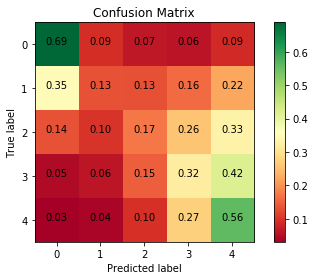

In [29]:
# show confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.cpu(), predicted.cpu())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest',cmap="RdYlGn")
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(5):
    for j in range(5):
        plt.text(j,i,format(cm[i][j],".2f"),horizontalalignment="center",color="black")
plt.tight_layout()
plt.savefig("logistic_conf.png")
cm